# Ensemble

In [53]:
# Import CNN, NN
import tensorflow as tf
cnn = tf.keras.models.load_model("CNN_leaf")
nn = tf.keras.models.load_model("NN.keras")

In [54]:
# Import RF, KNN, LR, SVC
from joblib import load
rf = load("leaf_model.pkl")
knn = load("knn_leaf_model.pkl")
lr = load("lr_leaf_model.pkl")
svc = load("svc_leaf_model.pkl")

# Import test data

In [55]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

(594, 256, 256)


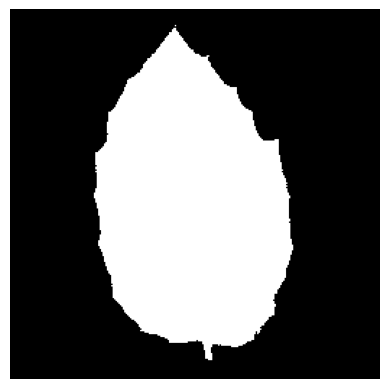

In [56]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Load and resize images
input_folder = "images"
size = 256
images=[]
for i in range(1,len(os.listdir(input_folder))+1):
    img = Image.open(os.path.join(input_folder, f"{i}.jpg")).convert("1")

    # Resize proportionally
    w, h = img.size
    scale = size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized = img.resize((new_w, new_h), Image.LANCZOS)

    # Create a size x size black background
    output = Image.new("L", (size, size), 0)

    # Paste centered
    x = (size - new_w) // 2
    y = (size - new_h) // 2
    output.paste(resized, (x, y))

    # Add to array
    img_array = np.array(output)
    images.append(img_array)
images = np.array(images)
test_id = test["id"].to_numpy(dtype=int)-1
X_comp = images[test_id]
print(X_comp.shape)

plt.imshow(X_comp[0], cmap='gray')
plt.axis('off')
plt.show()

In [57]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Convert y to integers
# Creates encoder and converts strings to integers
le = LabelEncoder()
y = le.fit_transform(train.species)
X = train.drop(['species'], axis = 1)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Predictions

In [59]:
# CNN
cnn_probs = cnn.predict(X_comp)

19/19 [==============================] - 1s 59ms/step


In [60]:
scaled  = scaler.transform(test)
nn_probs = nn.predict(scaled)

19/19 [==============================] - 0s 613us/step


In [83]:
x_test = test.drop('id', axis=1) if 'id' in test.columns else test
rf_probs = rf.predict_proba(x_test)
knn_probs = knn.predict_proba(x_test)
lr_probs = lr.predict_proba(x_test)
svc_probs = svc.predict_proba(test)

In [62]:
# Accuracy as weights
cnn_acc = 0.73
nn_acc = 0.97
svc_acc = 0.99
rf_acc = 0.97
knn_acc = 0.90
lr_acc = 0.92

In [78]:
weights = np.array([cnn_acc, nn_acc, svc_acc, rf_acc, knn_acc, lr_acc])
print(weights)
weights = weights / weights.sum() # Normalization
print(weights)

[0.73 0.97 0.99 0.97 0.9  0.92]
[0.13321168 0.1770073  0.18065693 0.1770073  0.16423358 0.16788321]


In [87]:
probs = [
    cnn_probs,
    nn_probs,
    svc_probs,
    rf_probs,
    knn_probs,
    lr_probs
]

In [91]:
# Ensemble
probs_stack = np.stack(probs)
ensemble_probs = np.tensordot(weights, probs_stack, axes=1)
ensemble_probs

array([[0.00906935, 0.00146833, 0.00154508, ..., 0.00373182, 0.00254675,
        0.00173447],
       [0.01459658, 0.0013171 , 0.00233116, ..., 0.00414369, 0.0023635 ,
        0.00197407],
       [0.00206544, 0.32515974, 0.00141191, ..., 0.00115168, 0.00120568,
        0.00597857],
       ...,
       [0.00229515, 0.00184096, 0.01513239, ..., 0.00135476, 0.00589726,
        0.00347917],
       [0.00325314, 0.00312908, 0.00173403, ..., 0.00606331, 0.00518184,
        0.00192483],
       [0.00096408, 0.00128461, 0.0018695 , ..., 0.00171785, 0.00382078,
        0.00211861]])

In [95]:
submission = pd.DataFrame(ensemble_probs, columns=le.classes_)
submission.insert(0, 'id', (test_id+1))
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.009069,0.001468,0.001545,0.001287,0.004767,0.001687,0.000993,0.009867,0.001629,...,0.001483,0.001278,0.005835,0.003301,0.001696,0.001124,0.001248,0.003732,0.002547,0.001734
1,7,0.014597,0.001317,0.002331,0.007262,0.001730,0.004793,0.003612,0.001661,0.010321,...,0.005569,0.003010,0.003183,0.001294,0.013552,0.002850,0.001526,0.004144,0.002364,0.001974
2,9,0.002065,0.325160,0.001412,0.001932,0.006101,0.002733,0.002997,0.002006,0.003758,...,0.001722,0.001097,0.001692,0.001614,0.001780,0.003869,0.002182,0.001152,0.001206,0.005979
3,12,0.003505,0.003826,0.001500,0.008131,0.001132,0.001126,0.003993,0.002332,0.002914,...,0.006203,0.003325,0.003658,0.003210,0.226986,0.026461,0.003748,0.001414,0.001367,0.004205
4,13,0.002072,0.011947,0.000979,0.002825,0.001049,0.001136,0.001282,0.003712,0.004947,...,0.004293,0.001059,0.014565,0.004272,0.002266,0.004069,0.004319,0.001212,0.001359,0.004482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,0.002378,0.328221,0.003458,0.002001,0.003952,0.002224,0.003021,0.001914,0.003655,...,0.001761,0.001188,0.001810,0.001534,0.001554,0.004258,0.002734,0.001259,0.001222,0.004534
590,1577,0.003277,0.003935,0.001877,0.007534,0.001442,0.000990,0.009082,0.002886,0.015422,...,0.001617,0.001574,0.005758,0.002150,0.010248,0.007940,0.002654,0.001355,0.001108,0.006891
591,1579,0.002295,0.001841,0.015132,0.001234,0.004878,0.002311,0.227301,0.002970,0.012740,...,0.001188,0.001629,0.002223,0.001729,0.003349,0.001036,0.012671,0.001355,0.005897,0.003479
592,1580,0.003253,0.003129,0.001734,0.004032,0.001128,0.001257,0.001461,0.001334,0.001172,...,0.002371,0.026308,0.001651,0.002200,0.008384,0.001702,0.001436,0.006063,0.005182,0.001925


In [97]:
# Make biggest proba 1 and all other 0
prob_cols = submission.columns[1:]  # all probability columns
submission_max = submission.copy()
submission_max[prob_cols] = (submission[prob_cols].values == submission[prob_cols].values.max(axis=1, keepdims=True)).astype(int)
submission_max.describe()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,...,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,780.673401,0.001684,0.010101,0.013468,0.015152,0.010101,0.006734,0.008418,0.013468,0.006734,...,0.018519,0.010101,0.008418,0.020202,0.003367,0.015152,0.010101,0.008418,0.005051,0.015152
std,465.646977,0.041030,0.100079,0.115365,0.122258,0.100079,0.081853,0.091437,0.115365,0.081853,...,0.134930,0.100079,0.091437,0.140809,0.057977,0.122258,0.100079,0.091437,0.070947,0.122258
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,368.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,774.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1184.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1583.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
submission.to_csv('ensemble_submission.csv', index=False)
submission_max.to_csv('ensemble_submission_max.csv', index=False)